<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [1]:
# if local
!conda activate cs685

/bin/bash: conda: command not found


In [2]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [5]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'
    DATA_PATH = r'C:\Users\faria\PycharmProjects\685\project\data\implicit-hate-corpus-nov-2021\implicit-hate-corpus'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [6]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [7]:
# !git status

install requirements from repo 

In [8]:
# for colab, use venv if in local
!pip install -r requirements.txt
!pip3 install emoji

     |████████████████████████████████| 4.0 MB 14.2 MB/s 
     |████████████████████████████████| 1.8 MB 67.5 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 880 kB 62.9 MB/s 
     |████████████████████████████████| 6.6 MB 58.5 MB/s 
     |████████████████████████████████| 181 kB 66.9 MB/s 
     |████████████████████████████████| 145 kB 70.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b56514778687f18ab3072077f77edfeee754bf7aa43a909647d1bd461452d5f2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=abac577085b5011a23d7094668b9893e756bcc0ff2d0c2092a330b0fdba395f3
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83e

load the helper and dataloader files

In [9]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [10]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [22]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)

set_seed(70)

In [12]:
data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [13]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

implicit_hate_dataset = Stage2Dataset(dataset_filename["stage-2"], drop_other=True, bertweet=True)

labels = implicit_hate_dataset.implicit_classes
# splitting into train and test set
train_idx, test_idx= train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels)
print(len(labels), len(train_idx), len(test_idx))
train_idx.sort()
print(np.arange(len(labels)))
print(train_idx)

# splitting into train and val set from train indices 
train_labels = list(map(labels.__getitem__, train_idx))
train_idx, val_idx= train_test_split(train_idx, test_size=0.25, shuffle=True, stratify=train_labels)
print(len(train_idx), len(val_idx))

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

# test_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=test_sampler)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


6266 5012 1254
[   0    1    2 ... 6263 6264 6265]
[   0    1    2 ... 6260 6262 6265]
3759 1253


In [24]:
# Confirming type is tensor
text, _, _, input_ids, attention_masks, labels, _ = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

print(text)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(' if you\'re white  you don\'t need to  " join " " anything . your skin is your uniform . have white children and teach the our culture "', "it's mexifornia, land of hemp fields and socialistsvery anti-citizen and pro-illegals", 'close border, or bring our soldiers back home to protect the taxpayers!', ': and as poor as they are  the predominantly white areas are still safer .', 'may he rest in peace . i didnt know him  i bet he was a good man . stood for what was right  the white race .', "so is the white hating  jew hating cult  the nation of islam . what's your point ?", ' european  " refugee " " crisis worsens #wakeupamerica #whitelivesmatter "', 'it seems people are willing to sell the future of western children for a momentary feeling of misguided moral superiority .')


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_idx, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    validation_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=sampler)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[3]
      input_mask_tensors = batch[4]
      label_tensors = batch[5]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_idx)
    final_score = precision_recall_fscore_support(predicted, labels, average='macro')
    class_names=['white_grievance', 'incitement', 'inferiority', 'irony', 'stereotypical', 'threatening']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1, 2, 3, 4, 5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [27]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "implicit_hate_detection_multi_class_bertweet",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [1e-5, 2e-5, 3e-5, 4e-5]
        },
        "random_seed" : {
          "values": [37, 69, 42]    
        },

        "epochs" : {
            "values" : [4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: 376mwgo6
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/376mwgo6


In [29]:
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = AutoModelForSequenceClassification.from_pretrained(
        "vinai/bertweet-base",
        num_labels = 6, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[3]
                input_mask_tensors = batch[4]
                label_tensors = batch[5]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_idx, config, epoch_i, "val")

            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'multiclass-bertweet-best-model-parameters.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val

            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_idx, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: m8vudod7 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 686.1925337314606


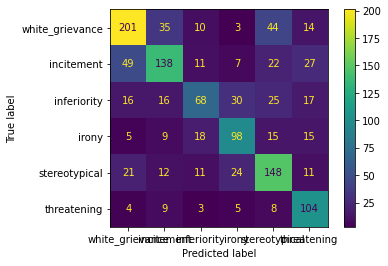

0.6066360528219962 0.5960129740466836 0.5945034055726636
Validation accuracy: 0.6041500399042299

======== Epoch 2 / 4 ========
Training...
Total loss: 463.9512640237808


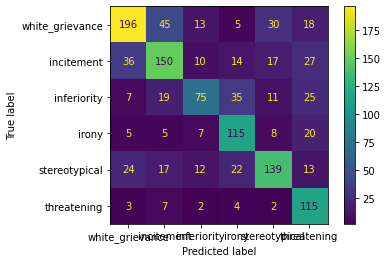

0.6434634384520688 0.6265912323324023 0.6234995524259354
Validation accuracy: 0.6304868316041501

======== Epoch 3 / 4 ========
Training...
Total loss: 339.4877356439829


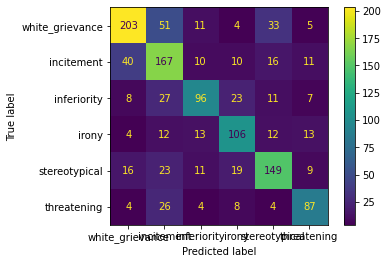

0.6416467730674568 0.6484741601273042 0.6430035596654412
Validation accuracy: 0.644852354349561

======== Epoch 4 / 4 ========
Training...
Total loss: 240.02944334596395


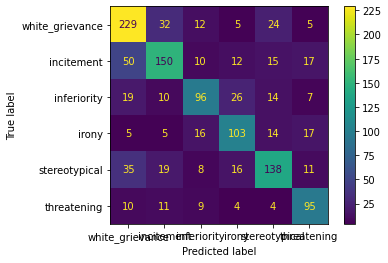

0.6434307140754191 0.6433949211679791 0.6414934232662142
Validation accuracy: 0.6472466081404629

Training complete!


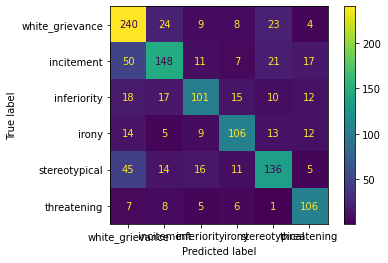

0.668081844012966 0.6724558151645542 0.6668663369080902
Test accuracy: 0.6674641148325359


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▇█▇▆█▆▆▆▄▆▄▄▆█▆▇▄▄▃▃▃▃▃▃▃▂▅▄▆▂▂▅▃▁▃▂▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▅██
val_f1,▁▅██
val_precision,▁███


wandb: Agent Starting Run: eo2mgihl with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 679.5417431592941


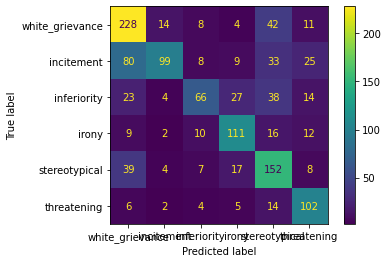

0.6077377561657102 0.629146746908139 0.5965469304692937
Validation accuracy: 0.6049481245011972

======== Epoch 2 / 4 ========
Training...
Total loss: 460.85329270362854


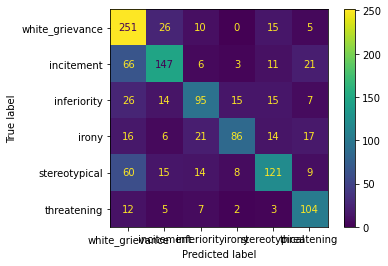

0.6335249750363388 0.6603038159061373 0.6368135917105197
Validation accuracy: 0.641660015961692

======== Epoch 3 / 4 ========
Training...
Total loss: 339.093571588397


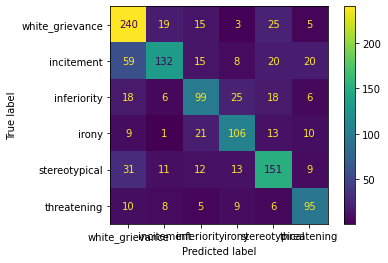

0.6531682240908027 0.6570184305893334 0.6505103225136692
Validation accuracy: 0.6568236233040702

======== Epoch 4 / 4 ========
Training...
Total loss: 242.03942274302244


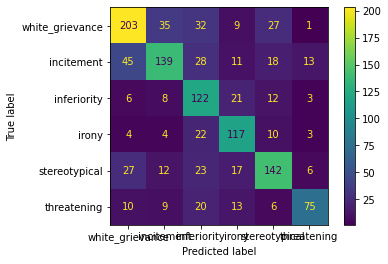

0.6397491067191522 0.6464900170840336 0.6359612923225926
Validation accuracy: 0.6368715083798883

Training complete!


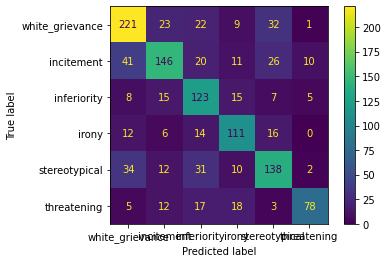

0.6493045274129183 0.6641032312120206 0.6507038387621877
Test accuracy: 0.6515151515151515


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,▇██▇▇▆█▅▃▆▃▃▅▄▃▄▆▆▅▄▃▂▃▂▂▂▂▅▃▁▂▃▁▂▂▁▃▁▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▆█▅
val_f1,▁▆█▆
val_precision,▁▅█▆


wandb: Agent Starting Run: bvkvpcpj with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 683.2037377953529


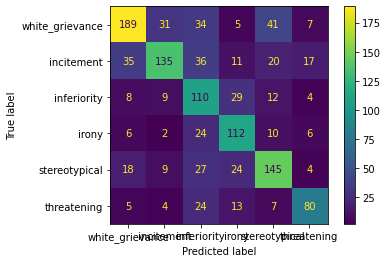

0.6211560675147393 0.6230572936271818 0.6144579561301533
Validation accuracy: 0.6153232242617718

======== Epoch 2 / 4 ========
Training...
Total loss: 454.224801838398


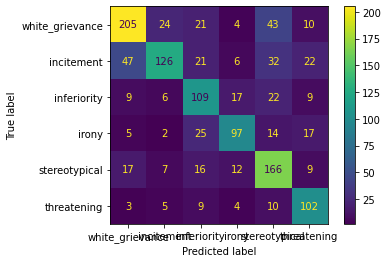

0.6503301986046691 0.6458421493073446 0.6397112399689502
Validation accuracy: 0.6424581005586593

======== Epoch 3 / 4 ========
Training...
Total loss: 334.90976674854755


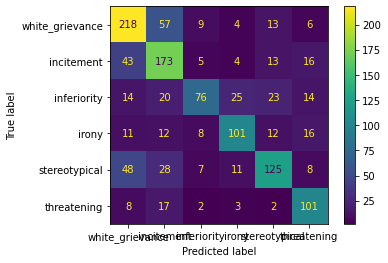

0.6290616393971423 0.6476467386210517 0.6297816764063214
Validation accuracy: 0.6336791699920191

======== Epoch 4 / 4 ========
Training...
Total loss: 240.1130266264081


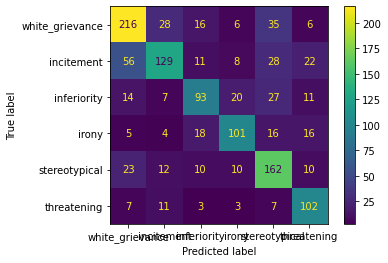

0.6439964054923614 0.6410809484651606 0.6374645409661814
Validation accuracy: 0.6408619313647247

Training complete!


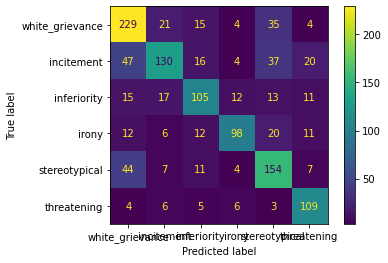

0.6627615172780207 0.6690172477251504 0.6599122841948811
Test accuracy: 0.6578947368421053


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,███▇▇▆▅▆▅▅▇▅▇▅▃▃▅▆▅▆▄▃▄▄▃▃▄▄▅▃▅▃▃▂▆▂▂▅▂▁
epoch,▁▁▁▁
loss,█▄▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▆█
val_f1,▁█▅▇
val_precision,▁█▃▆


wandb: Agent Starting Run: ok8inc5g with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 627.7253587841988


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


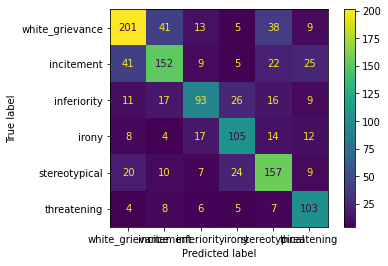

0.6526936740795882 0.6423897740237564 0.6445260336377873
Validation accuracy: 0.6472466081404629

======== Epoch 2 / 4 ========
Training...
Total loss: 416.31311087310314


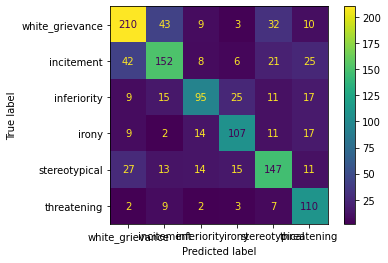

0.6630307713129284 0.6524587686411951 0.6529689093628798
Validation accuracy: 0.6552274541101357

======== Epoch 3 / 4 ========
Training...
Total loss: 277.6777458935976


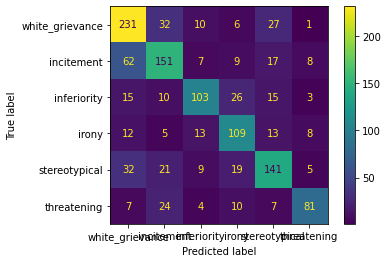

0.6428643876436153 0.664055208299682 0.6501504847825234
Validation accuracy: 0.6512370311252993

======== Epoch 4 / 4 ========
Training...
Total loss: 170.28218953683972


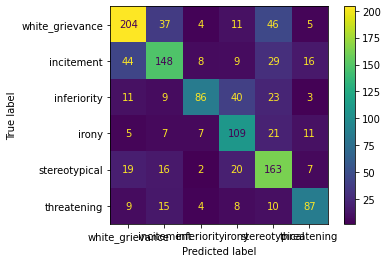

0.6334365486192535 0.6495455368938293 0.6334766652017308
Validation accuracy: 0.636073423782921

Training complete!


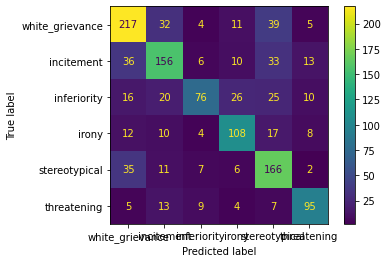

0.6471389286029406 0.6641416789471565 0.6484476675060628
Test accuracy: 0.6523125996810207


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▆█▆▇█▆▅▆▄▄▃▅▅▇▅▆▄▃▄▂▃▂▂▂▂▂▅▄▄▃▂▄▁▂▂▁▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▅█▇▁
val_f1,▅█▇▁
val_precision,▆█▃▁


wandb: Agent Starting Run: w6iej5g6 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 627.0369385182858


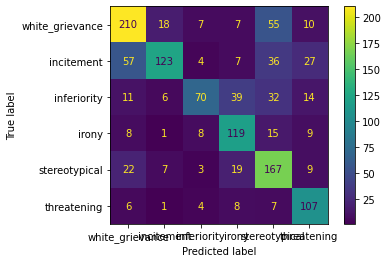

0.6432019830361025 0.6546031532508503 0.628981981816365
Validation accuracy: 0.6352753391859537

======== Epoch 2 / 4 ========
Training...
Total loss: 412.16883739829063


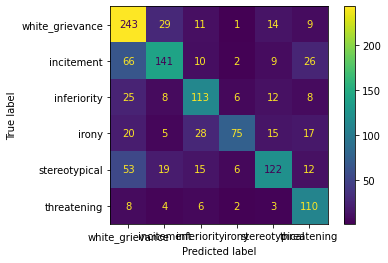

0.6394814003568852 0.6673750632887997 0.6372348930427821
Validation accuracy: 0.641660015961692

======== Epoch 3 / 4 ========
Training...
Total loss: 277.5091357752681


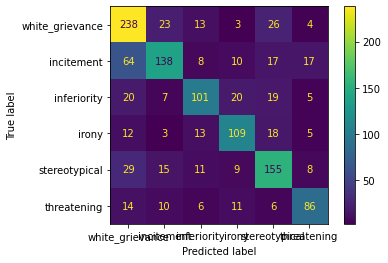

0.6527411022045527 0.6673080141258986 0.6564625031342549
Validation accuracy: 0.6600159616919393

======== Epoch 4 / 4 ========
Training...
Total loss: 172.65155104920268


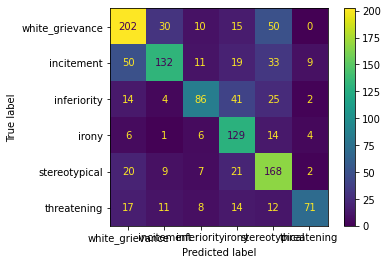

0.6263063645981958 0.6557229270517712 0.6253546839156783
Validation accuracy: 0.6288906624102155

Training complete!


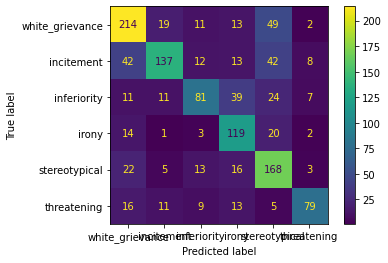

0.6308140178532939 0.6549394664009222 0.6312743753211943
Test accuracy: 0.6363636363636364


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,▇██▇▆▆▇▅▃▆▂▃▆▄▂▄▆▆▅▅▂▁▂▂▂▂▂▅▃▁▂▃▂▂▂▁▅▂▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▂▄█▁
val_f1,▂▄█▁
val_precision,▅▄█▁


wandb: Agent Starting Run: 0cb49zxt with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 622.7355045974255


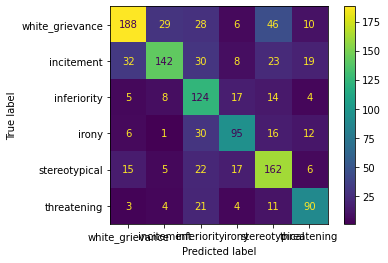

0.6460768863032915 0.645460325413977 0.6372106965141509
Validation accuracy: 0.6392657621707901

======== Epoch 2 / 4 ========
Training...
Total loss: 402.6721077412367


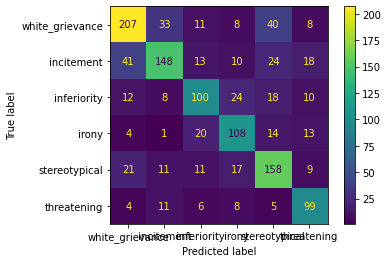

0.6589559599525211 0.6488748185561979 0.6513608512567575
Validation accuracy: 0.6544293695131684

======== Epoch 3 / 4 ========
Training...
Total loss: 262.5786187797785


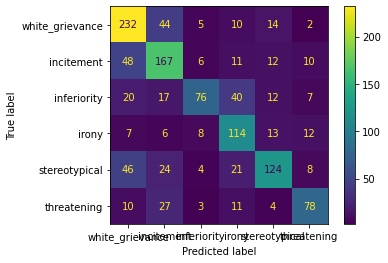

0.6167104629718786 0.6467183572186812 0.620506455272659
Validation accuracy: 0.6312849162011173

======== Epoch 4 / 4 ========
Training...
Total loss: 162.1265027411282


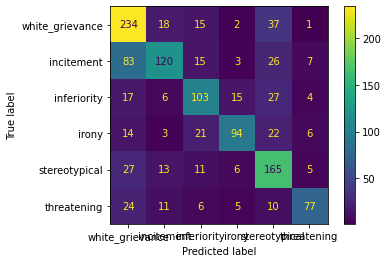

0.6211354588357764 0.6645787707751764 0.6317991943774418
Validation accuracy: 0.6328810853950518

Training complete!


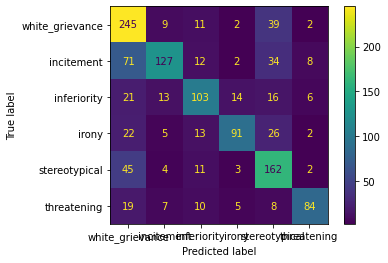

0.6347321078427791 0.6910890542154541 0.6493720093411534
Test accuracy: 0.6475279106858054


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▇▆▆▆▄▆▄▅▆▅█▃▂▃▅▇▆▆▄▃▅▄▃▃▂▃▆▂▃▂▃▂▅▂▁▁▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▃█▁▁
val_f1,▅█▁▄
val_precision,▆█▁▂


wandb: Agent Starting Run: zwqxohmk with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 609.2766596674919


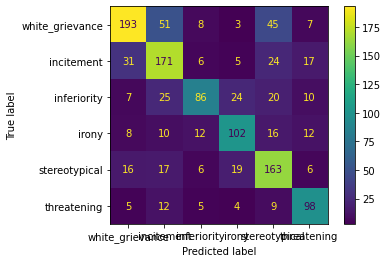

0.6490494368071112 0.6551432162508443 0.6466830366757416
Validation accuracy: 0.6488427773343974

======== Epoch 2 / 4 ========
Training...
Total loss: 401.814060151577


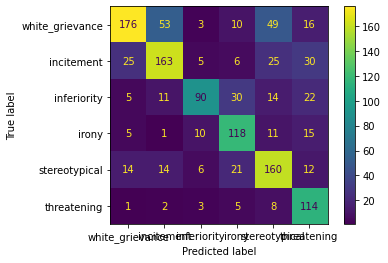

0.672961111969836 0.6636304552376665 0.6544323770693564
Validation accuracy: 0.6552274541101357

======== Epoch 3 / 4 ========
Training...
Total loss: 267.1703072413802


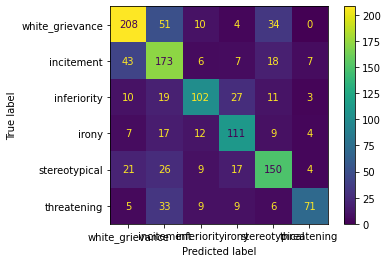

0.6400045976656867 0.6714875319532254 0.6491976680299039
Validation accuracy: 0.650438946528332

======== Epoch 4 / 4 ========
Training...
Total loss: 157.0140159726143


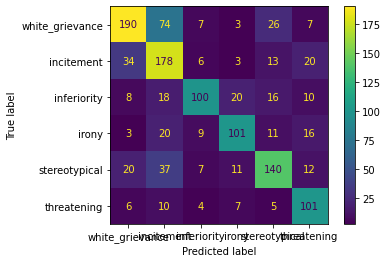

0.6514106404836105 0.6627552544947969 0.6507117380656959
Validation accuracy: 0.6464485235434956

Training complete!


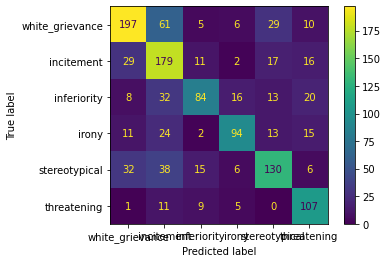

0.6330462339042894 0.6468882326026505 0.6312995695895186
Test accuracy: 0.6307814992025519


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▆█▆▇▇▅▄▇▅▄▄▄▅▆▆▆▄▂▃▃▃▂▂▂▃▂▆▄▅▃▂▄▁▁▂▁▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▃█▄▁
val_f1,▁█▃▅
val_precision,▃█▁▃


wandb: Agent Starting Run: 84rcqti7 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 611.3970834612846


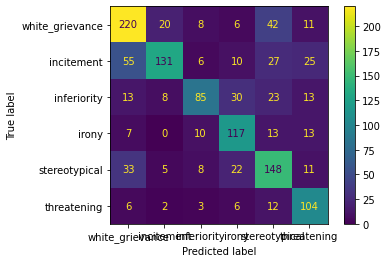

0.6486222869884207 0.6524665378504562 0.6386148644320064
Validation accuracy: 0.6424581005586593

======== Epoch 2 / 4 ========
Training...
Total loss: 406.0584744513035


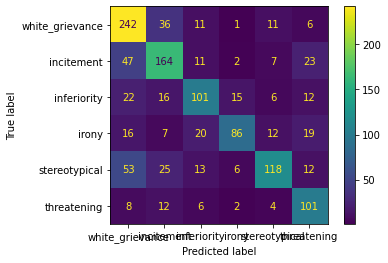

0.6396457490143668 0.6627408293159541 0.6407993776161826
Validation accuracy: 0.6480446927374302

======== Epoch 3 / 4 ========
Training...
Total loss: 275.35819625109434


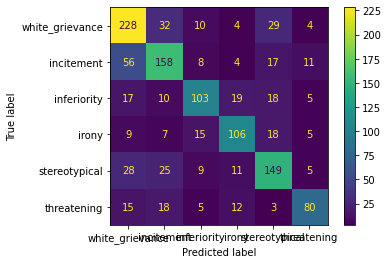

0.6473244812942558 0.668011843575583 0.6555646474873994
Validation accuracy: 0.6576217079010375

======== Epoch 4 / 4 ========
Training...
Total loss: 167.67510982230306


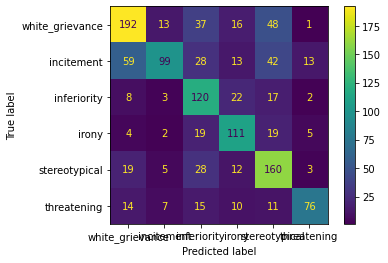

0.6138116251104223 0.6339836461522818 0.6058293229452333
Validation accuracy: 0.6049481245011972

Training complete!


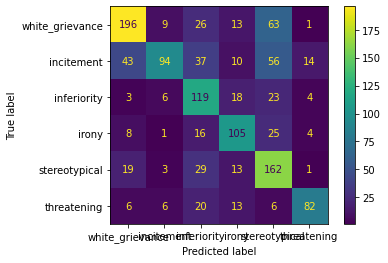

0.6141464579561068 0.642009454520622 0.6067030576150718
Test accuracy: 0.6044657097288676


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,▇██▇▅▆▇▅▃▆▂▂▆▆▂▄▆▆▅▅▂▁▂▂▁▂▂▅▂▁▁▃▁▂▂▁▆▂▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▆▇█▁
val_f1,▆▆█▁
val_precision,█▆█▁


wandb: Agent Starting Run: uqlkro2e with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 607.5485354065895


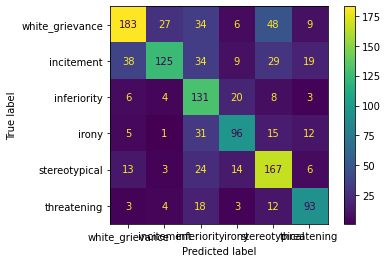

0.6474626726874085 0.64731008819561 0.6345758308458537
Validation accuracy: 0.6344772545889864

======== Epoch 2 / 4 ========
Training...
Total loss: 398.1160428673029


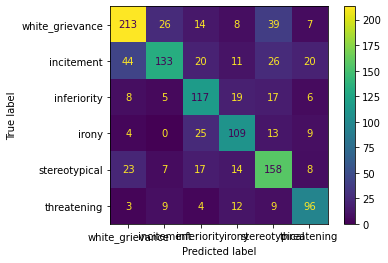

0.66612590564519 0.6575794836322754 0.6572890383107864
Validation accuracy: 0.659217877094972

======== Epoch 3 / 4 ========
Training...
Total loss: 258.7699397429824


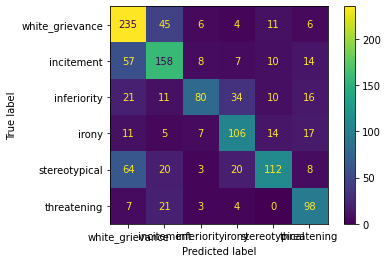

0.624228335269263 0.6476224751842379 0.6241967325306189
Validation accuracy: 0.6296887470071828

======== Epoch 4 / 4 ========
Training...
Total loss: 153.06728576868773


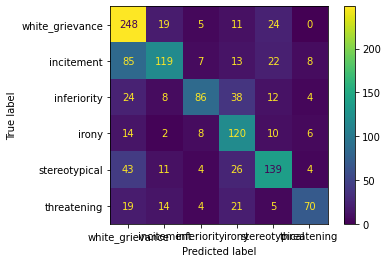

0.61082868630337 0.6592571523852926 0.6169153545395586
Validation accuracy: 0.6241021548284118

Training complete!


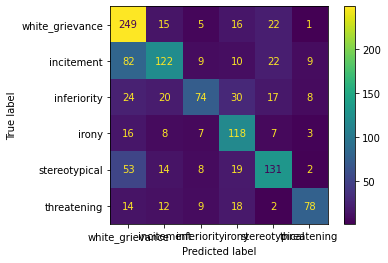

0.6036998708363314 0.6418685198854744 0.6086378685477017
Test accuracy: 0.6156299840510366


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,█▇▆▅▆▆▃▆▄▅▆▄█▃▂▃▅▆▆▅▃▂▅▅▂▃▃▃▆▁▂▂▃▁▄▃▂▄▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▃█▂▁
val_f1,▄█▂▁
val_precision,▆█▃▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fj7jkql4 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 608.4914408624172


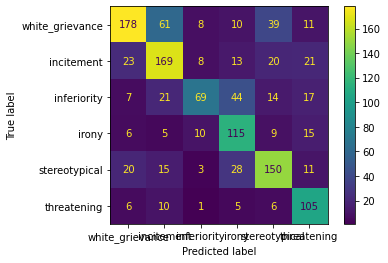

0.6358897195698833 0.6314215010474583 0.6202074339195843
Validation accuracy: 0.627294493216281

======== Epoch 2 / 4 ========
Training...
Total loss: 412.28771218657494


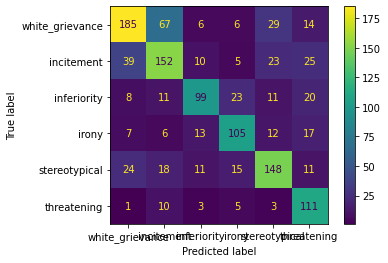

0.6532385500685755 0.6415914876400827 0.6413092554010198
Validation accuracy: 0.6384676775738228

======== Epoch 3 / 4 ========
Training...
Total loss: 278.4251550883055


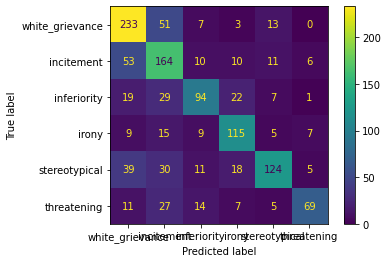

0.6224901788429699 0.6666870019499874 0.6344398316617396
Validation accuracy: 0.6376695929768555

======== Epoch 4 / 4 ========
Training...
Total loss: 184.1158426143229


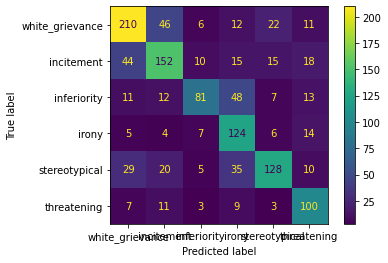

0.6406918114311525 0.6416294972705567 0.6294213107437001
Validation accuracy: 0.6344772545889864

Training complete!


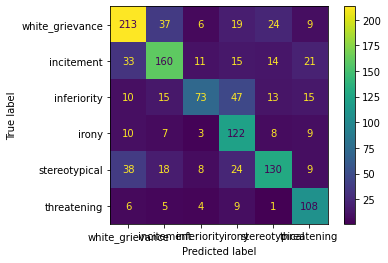

0.6492429861103145 0.6460384200752692 0.6352350947674643
Test accuracy: 0.6427432216905901


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▆█▆▇▇▅▄▇▄▃▄▄▄▆▅▆▄▂▄▂▅▁▁▃▂▂▆▂▅▂▃▅▂▁▂▁▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▇▆
val_f1,▁█▆▄
val_precision,▄█▁▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4dixycuq with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 614.5589589476585


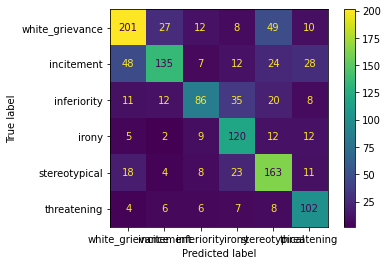

0.6535330262116416 0.6450777792570487 0.6400725973166026
Validation accuracy: 0.6440542697525937

======== Epoch 2 / 4 ========
Training...
Total loss: 415.6782022714615


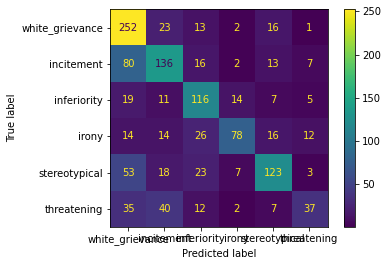

0.5563740483401476 0.611548957638575 0.5648642028255131
Validation accuracy: 0.5921787709497207

======== Epoch 3 / 4 ========
Training...
Total loss: 303.57856541872025


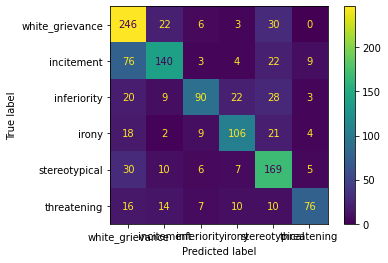

0.6423603019018067 0.6908029809470361 0.655373755026568
Validation accuracy: 0.6600159616919393

======== Epoch 4 / 4 ========
Training...
Total loss: 187.0581018179655


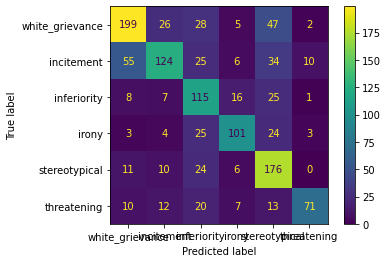

0.6242361799230091 0.6571266734036095 0.6270426699646927
Validation accuracy: 0.627294493216281

Training complete!


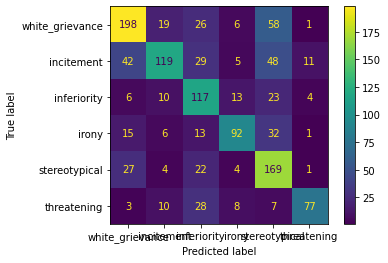

0.6149531284320824 0.652896340034597 0.6190761083373656
Test accuracy: 0.6156299840510366


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,▇██▇▆▆▇▆▃▆▂▂▅▅▃▄▅▇▆▅▄▃▂▂▁▁▁▄▃▁▂▄▄▂▃▁▅▂▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▆▁█▅
val_f1,▇▁█▆
val_precision,█▁▇▆


wandb: Agent Starting Run: jop6wjqm with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 604.3641776442528


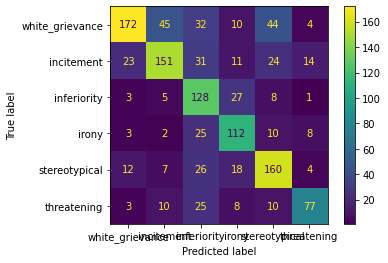

0.6471213342010417 0.6503623637201624 0.6378244947894506
Validation accuracy: 0.6384676775738228

======== Epoch 2 / 4 ========
Training...
Total loss: 397.8924244046211


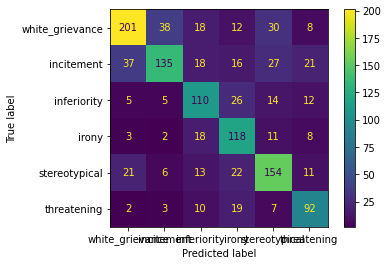

0.6555662489955761 0.6404552547507659 0.6423086347673509
Validation accuracy: 0.6464485235434956

======== Epoch 3 / 4 ========
Training...
Total loss: 259.5175265967846


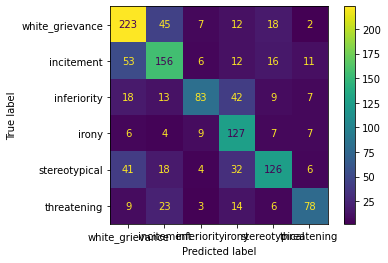

0.6263996629018126 0.6511536726965597 0.6272683439753508
Validation accuracy: 0.6328810853950518

======== Epoch 4 / 4 ========
Training...
Total loss: 158.22548151947558


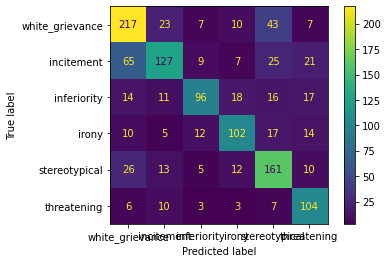

0.6489476523838051 0.6519939909409086 0.64343147664978
Validation accuracy: 0.6440542697525937

Training complete!


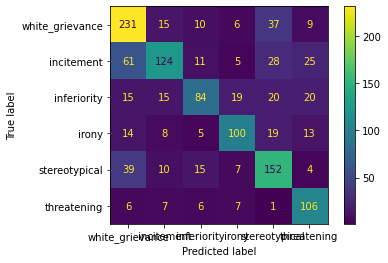

0.6365441553946791 0.6416434224757631 0.6304793225658143
Test accuracy: 0.6355661881977671


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,█▇▆▆▆▅▄▆▅▅▅▄█▄▁▂▅█▆▅▃▃▄▄▂▃▃▃▄▂▄▂▁▁▅▁▁▂▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▄█▁▇
val_f1,▆█▁█
val_precision,▆█▁▆


In [30]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")